In [176]:
import numpy as np
import pandas as pd

import json
import bz2

import regex

from bs4 import BeautifulSoup

import gensim
from gensim.models import word2vec 
from gensim.corpora import Dictionary
from gensim.models import TfidfModel
from gensim.models import LdaMulticore
from gensim.models import lsimodel

import nltk
import nltk.data
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer
nltk.download('punkt')

from tqdm import tqdm
from scipy import sparse
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import make_multilabel_classification
from sklearn.metrics import classification_report
from scipy.sparse import csr_matrix

from sklearn.pipeline import Pipeline

import torch
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Vladimir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:02, 1645.71it/s]


In [3]:
responses[0]

{'city': 'г. Москва',
 'rating_not_checked': False,
 'title': 'Жалоба',
 'num_comments': 0,
 'bank_license': 'лицензия № 2562',
 'author': 'uhnov1',
 'bank_name': 'Бинбанк',
 'datetime': '2015-06-08 12:50:54',
 'text': 'Добрый день! Я не являюсь клиентом банка и поручителем по кредитному договору, а также не являюсь каким-либо другим лицом, письменно  оформившим отношения с банком по поводу урегулирования чьей-либо  задолженности.  Начиная с марта 2015 года начали приходить бесконечные письма из ООО "Примо коллект"на мой адрес: город Москва, Уваровский переулок, дом 10, квартира 111, с угрозами о возбуждении уголовного дела в отношении гражданина Филиппова Эдуарда Владимировича, который уклоняется от уплаты взятых им кредитов: договор № 81014 от 20.10.2013 года и договор № 2464946 от 09.10.2014 года. Со всей ответственностью\xa0 хочу Вас заверить, что вышеуказанный гражданин, которого Вы разыскиваете, мне не знаком и никогда в моем адресе не был зарегистрирован. Каким образом Вы не удо

In [4]:
def json_to_pd(review):
    city = []
    rating_not_checked = []
    title = []
    num_comments = []
    bank_license = []
    author = []
    bank_name = []
    datetime = []
    text = []
    rating_grade = []
    
    for rec in review:
        city.append(rec['city'])
        rating_not_checked.append(rec['rating_not_checked'])
        title.append(rec['title'])
        num_comments.append(rec['num_comments'])
        bank_license.append(rec['bank_license'])
        author.append(rec['author'])
        bank_name.append(rec['bank_name'])
        datetime.append(rec['datetime'])
        text.append(rec['text'])
        rating_grade.append(rec['rating_grade'])
    return pd.DataFrame(
        {
            'city': city,
            'rating_not_checked': rating_not_checked,
            'title': title,
            'num_comments': num_comments,
            'bank_license': bank_license,
            'author': author,
            'bank_name': bank_name,
            'datetime': datetime,
            'text': text,
            'rating_grade': rating_grade
            
        }
    )
        

In [5]:
df = json_to_pd(responses)

In [6]:
df.head(3)

,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,г. Москва,False,Жалоба,0,лицензия № 2562,uhnov1,Бинбанк,2015-06-08 12:50:54,Добрый день! Я не являюсь клиентом банка и пор...,NaN
1,г. Новосибирск,False,Не могу пользоваться услугой Сбербанк он-лайн,0,лицензия № 1481,Foryou,Сбербанк России,2015-06-08 11:09:57,Доброго дня! Являюсь держателем зарплатной кар...,NaN
2,г. Москва,False,Двойное списание за один товар.,1,лицензия № 2562,Vladimir84,Бинбанк,2015-06-05 20:14:28,Здравствуйте! Дублирую свое заявление от 03.0...,NaN


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   city                138325 non-null  object 
 1   rating_not_checked  153499 non-null  bool   
 2   title               153499 non-null  object 
 3   num_comments        153499 non-null  int64  
 4   bank_license        153498 non-null  object 
 5   author              153479 non-null  object 
 6   bank_name           153499 non-null  object 
 7   datetime            153499 non-null  object 
 8   text                153499 non-null  object 
 9   rating_grade        88658 non-null   float64
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


In [8]:
# отфильтруем только записи, содержащие ненулевой рейтинг
df_score = df[(df['rating_grade'].isna() == False) & (df['text'].isna() == False)].reset_index()[['text', 'rating_grade']]

In [9]:
df_score

,text,rating_grade
0,"Также как и многие давний клиент банка, был до...",2.0
1,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0
2,Доброго времени! Вчера мне поступило смс-уведо...,1.0
3,"05.06.2015г. около 15 часов, пришел в указанны...",1.0
4,Для оплаты коммунальных платежей пользуюсь пла...,1.0
...,...,...
88653,"Слишком большой банк, не всегда учитывает нашу...",5.0
88654,"Вы сами виноваты в своих проблемах, кроме пред...",3.0
88655,Уважаемое руководство банка «ОВК»! Я проживаю ...,1.0
88656,Пробовала 10.04.05 оформить товар в кредит в А...,1.0


In [10]:
def review_to_wordlist(review, lemmatizer, remove_stopwords=False):
    # убираем ссылки
    review_text = re.sub(r"http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+", " ", review)
    # достаем сам текст
    # review_text = BeautifulSoup(review_text, "lxml").get_text()
    # оставляем только буквенные символы
    review_text = re.sub("[^а-яА-ЯёЁ]"," ", review_text)
    # приводим к нижнему регистру и разбиваем на слова по символу пробела
    words = review_text.lower().split()
    if remove_stopwords: # убираем стоп-слова
        russian_stopwords = stopwords.words("russian")
        #stops = stopwords.words("english")
        words = [w for w in words if not w in russian_stopwords]
    if lemmatizer:
        return([lemmatizer.parse(word)[0].normal_form for word in words])
    else:
        return words
    
def review_to_sentences(review, tokenizer, lemmatizer = None, remove_stopwords=False):
    # разбиваем обзор на предложения
    raw_sentences = tokenizer.tokenize(review.strip())
    sentences = []
    # применяем предыдущую функцию к каждому предложению
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append(review_to_wordlist(raw_sentence, lemmatizer, remove_stopwords))
    return sentences

In [19]:
sentences_no_lemm = []  
print('Parsing sentences...')
for review in tqdm(df['text']):
    sentences_no_lemm += review_to_sentences(review, tokenizer)

Parsing sentences...


100%|█████████████████████████████████████████████████████████████████████████| 153499/153499 [03:42<00:00, 691.17it/s]


In [11]:
tokenizer = nltk.data.load('tokenizers/punkt/russian.pickle')
lemmatizer = MorphAnalyzer()

In [24]:
sentences = []  
print('Parsing sentences...')
for review in tqdm(df['text']):
    sentences += review_to_sentences(review, tokenizer, lemmatizer)

Parsing sentences...


100%|████████████████████████████████████████████████████████████████████████| 153499/153499 [2:48:33<00:00, 15.18it/s]


In [28]:
sentences[0:2]

[['добрый', 'день'],
 ['я',
  'не',
  'являться',
  'клиент',
  'банка',
  'и',
  'поручитель',
  'по',
  'кредитный',
  'договор',
  'а',
  'также',
  'не',
  'являться',
  'какой',
  'либо',
  'другой',
  'лицо',
  'письменно',
  'оформить',
  'отношение',
  'с',
  'банк',
  'по',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность']]

In [26]:
#запись результатов в файл:
with open('text_banki_lem.txt', 'w') as f:
    for s in sentences:
        f.write(' '.join(s))
        f.write('\n')

In [13]:
#считать результаты из файла:
import csv
sentences = []
with open('text_banki_lem.txt', 'r', newline='') as csvfile:
    r = csv.reader(csvfile, delimiter=' ')
    sentences.append(list(r))
sentences = sentences[0]

In [14]:
sentences[0:2]

[['добрый', 'день'],
 ['я',
  'не',
  'являться',
  'клиент',
  'банка',
  'и',
  'поручитель',
  'по',
  'кредитный',
  'договор',
  'а',
  'также',
  'не',
  'являться',
  'какой',
  'либо',
  'другой',
  'лицо',
  'письменно',
  'оформить',
  'отношение',
  'с',
  'банк',
  'по',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность']]

In [15]:
russian_stopwords = stopwords.words("russian")

In [16]:
sentences_no_sw = sentences.copy()

In [17]:
for i, text in enumerate(sentences_no_sw):
    for word in text:
        if word in russian_stopwords:
            while word in sentences_no_sw[i]:
                sentences_no_sw[i].remove(word) 

In [18]:
sentences_no_sw[0:2]

[['добрый', 'день'],
 ['являться',
  'клиент',
  'банка',
  'поручитель',
  'кредитный',
  'договор',
  'также',
  'являться',
  'какой',
  'либо',
  'лицо',
  'письменно',
  'оформить',
  'отношение',
  'банк',
  'повод',
  'урегулирование',
  'чей',
  'либо',
  'задолженность']]

# Часть 1. Анализ Текстов

In [20]:
df_score_all = df[(df['rating_grade'].isna() == False) & (df['text'].isna() == False)].reset_index()

In [21]:
df_score_all.head(5)

,index,city,rating_not_checked,title,num_comments,bank_license,author,bank_name,datetime,text,rating_grade
0,14,г. Москва,False,В Шоке,0,лицензия № 2673,yura1189,Тинькофф Банк,2015-06-05 13:52:40,"Также как и многие давний клиент банка, был до...",2.0
1,19,г. Москва,False,Некомпетентность сотрудников банка,2,лицензия № 1481,agelun,Сбербанк России,2015-06-05 15:00:54,Открыт вклад и счет в USD. Плюс к этому есть з...,1.0
2,33,г. Ростов-на-Дону,False,Навязывание страховки,1,лицензия № 1481,Joker888,Сбербанк России,2015-06-05 21:35:40,Доброго времени! Вчера мне поступило смс-уведо...,1.0
3,76,г. Санкт-Петербург,False,Нарушение договора банковского вклада,0,лицензия № 3006,qwarta45,АктивКапитал Банк,2015-06-06 23:42:39,"05.06.2015г. около 15 часов, пришел в указанны...",1.0
4,85,г. Москва,False,"Невозможно оплатить отчисления на капремонт ""Т...",4,лицензия № 1481,721,Сбербанк России,2015-06-04 13:27:04,Для оплаты коммунальных платежей пользуюсь пла...,1.0


## 1.1 Количество отзывов по городам:

In [21]:
df_score_all['city'].value_counts()

г. Москва                               32502
г. Санкт-Петербург                       8035
г. Екатеринбург                          1275
г. Новосибирск                           1148
г. Нижний Новгород                       1086
                                        ...  
г. кондрово                                 1
г. Раменское, Московской обл.               1
г. Фурманов                                 1
г. Рогачево                                 1
г. Краснодарский край, ст.Павловская        1
Name: city, Length: 3581, dtype: int64

## 1.2 Количество отзывов по банкам:

In [22]:
df_score_all['bank_name'].value_counts()

Сбербанк России      14944
Альфа-Банк            5378
ВТБ 24                4776
Русский Стандарт      4368
Хоум Кредит Банк      4028
                     ...  
Ростпромстройбанк        1
Нарат                    1
Татагропромбанк          1
Прайм Финанс             1
Новопокровский           1
Name: bank_name, Length: 619, dtype: int64

## 1.3 Количество отзывов по городам и банкам (ТОП10):

In [23]:
pivot_table = pd.pivot_table(df_score_all, values='index', index=['city', 'bank_name'], aggfunc='count', sort=True)

In [24]:
pivot_table.reset_index().sort_values(by=['index'], ascending = False).rename(columns={'index': 'Count of scores'}).head(10)

,city,bank_name,Count of scores
4670,г. Москва,Сбербанк России,4627
4411,г. Москва,Альфа-Банк,2041
4656,г. Москва,Русский Стандарт,1645
4454,г. Москва,ВТБ 24,1542
8092,г. Санкт-Петербург,Сбербанк России,1383
4567,г. Москва,Московский Кредитный Банк,1371
4736,г. Москва,Хоум Кредит Банк,1292
4579,г. Москва,Национальный Банк «Траст»,1036
4626,г. Москва,Райффайзенбанк,964
4705,г. Москва,Тинькофф Банк,947


## 2. Гистограмма распределения длинн слов-лемм в символах:

In [25]:
#составим словарь вида токен-id
dictionary = Dictionary(sentences)

In [26]:
#вычислим в словаре длины встречающихся слов
len_tokens = [len(k) for k, v in dictionary.token2id.items()]

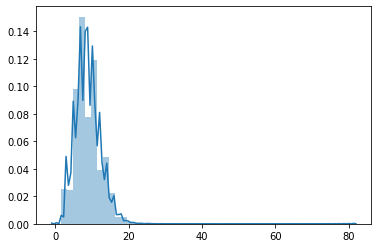

In [27]:
sns_plot = sns.distplot(len_tokens)
fig = sns_plot.get_figure()

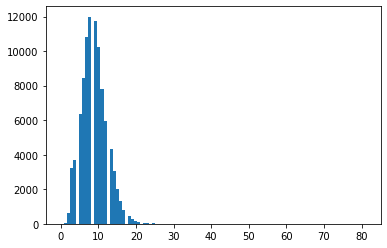

In [28]:
plt.hist(len_tokens, bins=100)
plt.show()

Самые часто встречающиеся в словаре слова имеют длинну 7-9 символов:

In [29]:
import collections
c = collections.Counter()
for word in len_tokens:
    c[word] += 1
c.most_common(3)

[(8, 11990), (9, 11739), (7, 10839)]

## 3.1 ТОР10 самых встечаемых слов-лемм: 

In [30]:
#словарь вида токент-id
dictionary.token2id['добрый']

1

In [31]:
# частота встречаемости токенов во всех документах
dictionary.cfs[0]

170152

In [32]:
#отсортируем словарь по частоте встречаемости токенов (id-частота)
import operator
sorted_cfs = sorted(dictionary.cfs.items(), key=operator.itemgetter(1), reverse = True)

Самые часто встречаемые токены как и ожидалось относятся к стоп-словам:

In [33]:
top_freq_keys = [k for k, v in sorted_cfs[:10]]
[dictionary[i] for i in top_freq_keys]

['банка', 'карта', 'это', 'банк', 'весь', 'деньга', 'я', 'день', 'год', 'не']

## 3.2 ТОР10 самых встечаемых слов-лемм без стоп-слов: 

In [34]:
dictionary_no_sw = Dictionary(sentences_no_sw)

In [35]:
sorted_cfs_no_sw = sorted(dictionary_no_sw.cfs.items(), key=operator.itemgetter(1), reverse = True)

In [36]:
top_freq_keys_no_sw = [k for k, v in sorted_cfs_no_sw[:10]]
[dictionary_no_sw[i] for i in top_freq_keys_no_sw]

['банка', 'карта', 'это', 'банк', 'весь', 'деньга', 'я', 'день', 'год', 'не']

## 3.3 ТОР10 самых встечаемых слов (без лемматизации):

In [37]:
dictionary_no_lemm = Dictionary(sentences_no_lemm)

In [38]:
import operator
sorted_cfs_no_lemm = sorted(dictionary_no_lemm.cfs.items(), key=operator.itemgetter(1), reverse = True)

In [39]:
top_freq_keys_no_lemm = [k for k, v in sorted_cfs_no_lemm[:10]]
[dictionary_no_lemm[i] for i in top_freq_keys_no_lemm]

['в', 'и', 'не', 'на', 'что', 'я', 'с', 'по', 'мне', 'банка']

## 3.4 ТОР10 самых встечаемых слов - существительных (без лемматизации):

In [40]:
nouns_no_lemm = []
for k, v in sorted_cfs_no_lemm:
    if lemmatizer.parse(dictionary_no_lemm[k])[0].tag.POS == 'NOUN':
        nouns_no_lemm.append(dictionary_no_lemm[k])
    if len(nouns_no_lemm) == 10:
        break

In [41]:
nouns_no_lemm

['банка',
 'банк',
 'деньги',
 'карту',
 'карты',
 'т',
 'кредит',
 'день',
 'раз',
 'банке']

## 3.5 ТОР10 самых встечаемых слов - существительных (леммы):

In [42]:
nouns_lemm = []
for k, v in sorted_cfs:
    if lemmatizer.parse(dictionary[k])[0].tag.POS == 'NOUN':
        nouns_lemm.append(dictionary[k])
    if len(nouns_lemm) == 10:
        break

In [43]:
nouns_lemm

['банка',
 'карта',
 'банк',
 'деньга',
 'день',
 'год',
 'кредит',
 'отделение',
 'клиент',
 'сотрудник']

## 4. Кривые Ципфа и Хипса

In [44]:
#Расчет рядов для кривой Ципфа
freq = []
rank = []
for i, (k, v) in enumerate(sorted_cfs):
    freq.append(v)
    rank.append(i)

In [45]:
#Расчет рядов для кривой Хипса
dic = {} # словарь вида ключ- длина предложения; значение - массив из колиечества уникальных слов в предолжении (потом среднее)
prev = []
for text in sentences:
    if dic.get(len(text)) != None:
        prev = dic[len(text)]
        if len(set(text)) not in prev:
            prev.append(len(set(text)))
            dic[len(text)] = prev         
    else:
        dic[len(text)] = [len(set(text))]


In [46]:
#для для предложений определенной длинны есть разные варианты колиечества уникальных слов, берем среднее арифметическое по ним
dic_average = {}
for key, value in dic.items():
    dic_average[key] = round(mean(value))

In [47]:
sorted_dic_av = sorted(dic_average.items(), key=operator.itemgetter(0), reverse = False)

In [48]:
x = []
y = []
for slen, ulen in sorted_dic_av:
    x.append(slen)
    y.append(ulen)

<function matplotlib.pyplot.show(*args, **kw)>

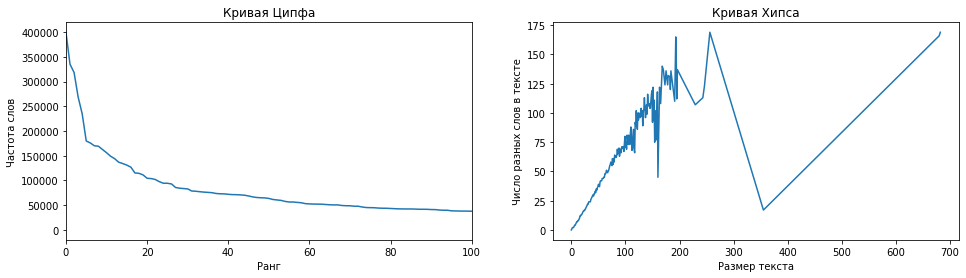

In [49]:
plt.figure(figsize=(16,4))

plt.subplot(121)
plt.plot(rank, freq)
plt.xlim(0, 100)
plt.title('Кривая Ципфа')
plt.xlabel('Ранг')
plt.ylabel('Частота слов')

plt.subplot(122)
plt.plot(x, y)
plt.title('Кривая Хипса')
plt.xlabel('Размер текста')
plt.ylabel('Число разных слов в тексте')

plt.show

Действительно, закон Ципфа показывает имеет обратноую зависимость между частотой втречаемости слова и его рангом (порядковый номер в списке по убыванию частотности). Закон Хипса ввиду малого объема предложений с уникальными длинами преолжений >180 слов показывают, что с увелиечением длинны предложения, количество уникальных слов в нем возрастает с меньшим темпом.  

## 5. Ответы на вопросы

### 5.1 какое слово встречается чаще, "сотрудник" или "клиент"?

In [50]:
#Найдем id слов в словаре
dictionary.token2id['сотрудник']

455

In [51]:
dictionary.token2id['клиент']

7

In [54]:
#Посмотрим как часто встречаются данные слова в предложениях
dictionary.cfs[dictionary.token2id['сотрудник']]

134168

In [55]:
dictionary.cfs[dictionary.token2id['клиент']]

136893

Слово "клиент" чаще встречается в предолжениях (136893 раза), нежели слово "сотрудник".

### 5.2 сколько раз встречается слова "мошенничество" и "доверие"?

In [56]:
#Найдем id слов в словаре
dictionary.token2id['мошенничество']

2498

In [57]:
dictionary.token2id['доверие']

1792

Слово "мошенничество" встречается 2498 раз, а слово "доверие" только 1792 раз

## 6. Найдем ключевые слова и биграммы для положительных (оценка 5) и отрицательных (оценка 1) отзывов

In [56]:
df5 = df[(df['rating_grade'] == 5.0) & (df['text'].isna() == False)].reset_index()[['text', 'rating_grade']]

In [57]:
df1 = df[(df['rating_grade'] == 1.0) & (df['text'].isna() == False)].reset_index()[['text', 'rating_grade']]

In [60]:
df5.head(5)

,text,rating_grade
0,Досрочно закрывали вклады перед отпуском. Жена...,5.0
1,"Хотел открыть вклад ""Доходный+"" под 19% год , ...",5.0
2,"Вчера, 3 июня, просидев в очереди более 3-х ча...",5.0
3,Сегодня открывал вклад в этом банке. Очередь б...,5.0
4,Моя история получения кредита в Ренессанс Кред...,5.0


In [58]:
#для всех отзывов с оценкой 5 проводим обратботку текста (ткоенизируем, удаляем лишние символы)
sentences5 = []  
print('Parsing sentences...')
for review in tqdm(df5['text']):
    sentences5.append(review_to_sentences(review, tokenizer, lemmatizer, True))

Parsing sentences...


100%|████████████████████████████████████████████████████████████████████████████| 14713/14713 [09:48<00:00, 24.99it/s]


In [59]:
sentences1 = []  
print('Parsing sentences...')
for review in tqdm(df1['text']):
    sentences1.append(review_to_sentences(review, tokenizer, lemmatizer, True))

Parsing sentences...


100%|████████████████████████████████████████████████████████████████████████████| 47387/47387 [40:06<00:00, 19.69it/s]


In [60]:
#в sentence5 разбито на предолжения. мы группируем по отзывам. т.е. если в отзыве несколько предолжений, то объединяем в одну строку
sent5 = []
for i, review in enumerate(sentences5):
    if len(review) > 1:
        res = []
        x = []
        x = [sentence for sentence in review if sentence != []]
        if x != []:
            res = list(concatenate(x))
    else:
        res = review[0]
    sent5.append(res)

In [61]:
sent1 = []
for i, review in enumerate(sentences1):
    if len(review) > 1:
        res = []
        x = []
        x = [sentence for sentence in review if sentence != []]
        if x != []:
            res = list(concatenate(x))
    else:
        res = review[0]
    sent1.append(res)

In [62]:
#заменим слово "банка" на "банк"
for isent,sentence in enumerate(sent5):
    for iword, word in enumerate(sentence):
        if word == 'банка':
            sent5[isent][iword] = 'банк'


In [63]:
for isent,sentence in enumerate(sent1):
    for iword, word in enumerate(sentence):
        if word == 'банка':
            sent1[isent][iword] = 'банк'

In [388]:
dictionary5 = Dictionary(sent5)
corpus5 = [dictionary5.doc2bow(text) for text in sent5]

In [391]:
dictionary1 = Dictionary(sent1)
corpus1 = [dictionary1.doc2bow(text) for text in sent1]

In [389]:
tfidf5 = TfidfModel(corpus5)
corpus_tfidf5 = tfidf5[corpus5]

In [392]:
tfidf1 = TfidfModel(corpus1)
corpus_tfidf1 = tfidf1[corpus1]

In [393]:
def maxnIndSort(arr, dic, topn = 5):
    ww = [w for i, w in arr]
    ind = [i for i, w in arr]
    max_indices = sorted(range(len(ww)), key=lambda i: ww[i], reverse=True)[:topn]
    return [ind[i] for i in max_indices], [ww[i] for i in max_indices], [dic[ind[i]] for i in max_indices]

Ключевые слова для отзывов с рейтингом 5, полученных из модели tf-idf:

In [394]:
for i in range(20):
    print(maxnIndSort(corpus_tfidf5[i], dictionary5, topn = 5)[2])

['ленсовет', 'озерко', 'прикрыть', 'доступность', 'нести']
['доходный', 'вклад', 'взнос', 'снизить', 'первоначальный']
['июнь', 'выплата', 'выгнать', 'спасть', 'наплыть']
['какао', 'зав', 'наличие', 'туалет', 'затратить']
['страховка', 'гигабайт', 'ммс', 'сроккредит', 'евт']
['реструктуризация', 'неугодов', 'обрисовать', 'наталия', 'приглашение']
['депозит', 'располагаться', 'размещать', 'руководитель', 'подразделение']
['сетель', 'просрочить', 'регион', 'начислить', 'корректно']
['настолько', 'мудрец', 'отрада', 'шлёнский', 'ярина']
['георгий', 'тодуа', 'впадать', 'тимирязевский', 'чужой']
['тикета', 'кошелёк', 'просить', 'оферта', 'владение']
['плат', 'поль', 'интерактивный', 'некачественный', 'использование']
['камышин', 'доставка', 'заказать', 'емэйл', 'консультантка']
['поменять', 'автовый', 'сравнение', 'паспорт', 'познаваться']
['навстеча', 'начислиться', 'наступление', 'должник', 'тянуть']
['балл', 'сбербанк', 'пароль', 'чек', 'идентификатор']
['переход', 'ссылка', 'инуть', 'шо

In [357]:
df5['text'].head(1).values

array(['Досрочно закрывали вклады перед отпуском. Жена заказывала заранее, но забыла заказать на меня. Сотрудник банка (СПБ Ленсовета 89) Наталья не отказала мне, хотя сумма значительная. Работает быстро, профессионально. Ничего лишнего. Жаль, что прикрыли прием вкладов в офисе Озерки - доступность офиса для меня. Заметил, что и несут деньги во вклады и берут кредиты. Желаю успехов банку.'],
      dtype=object)

Ключевые слова для отзывов с рейтингом 1, полученных из модели tf-idf:

In [395]:
for i in range(20):
    print(maxnIndSort(corpus_tfidf1[i], dictionary1, topn = 5)[2])

['доллар', 'курс', 'долларовый', 'операционист', 'риторический']
['страховка', 'одобрить', 'страхование', 'самопроизвольно', 'сотрудник']
['менежер', 'вклад', 'неизменность', 'приказывать', 'винтик']
['капремонт', 'отчисление', 'внешний', 'лицевой', 'коммунальный']
['квитанция', 'расписаться', 'положить', 'уверенность', 'чапаевск']
['бки', 'обновляться', 'тянуться', 'обновить', 'продолжение']
['привелигировать', 'клуб', 'евровой', 'евровую', 'операционистка']
['сытый', 'клерк', 'легко', 'репутация', 'заявлять']
['тихвинский', 'оправдываться', 'привозить', 'долларовый', 'двадцать']
['терминал', 'симферопольский', 'стартовый', 'переключиться', 'рассмотрение']
['техносёл', 'своевременный', 'молча', 'отказ', 'письмо']
['терминал', 'вклад', 'пополнение', 'пополнить', 'торопиться']
['платёжный', 'связанный', 'минимизация', 'установленный', 'эквайер']
['развод', 'абсолютно', 'средь', 'совдеповский', 'безучастный']
['операционистка', 'заказать', 'вклад', 'раздвижной', 'средневысокий']
['отмена

In [396]:
df1['text'].head(1).values

array(['Открыт вклад и счет в USD. Плюс к этому есть зарплатная карта, в рублях, само собой. Сегодня пришел в указанное отделение с целью пополнить долларовый счёт на 700 USD.\xa0Дал операционисту паспорт, зарплатную карту (т.к. на окошке написано "приготовьте карту для подтверждения операции" или что-то подобное и в прошлый раз у меня ее потребовали) и сказал, что нужно положить деньги на ДОЛЛАРОВЫЙ счет.\xa0Операционист всё взяла, что-то делала-крутила-вертела, вставила карту в терминал, сказала "введите пин", я ввёл пин, получил в ответ чек, где было написано, что доллары были внесены.... на счёт КАРТЫ! в РУБЛЯХ! Вопрос банку №1, риторический:  Я не понимаю, кем нужно быть, чтобы сознательно проводить такие операции??? за углом, меньше чем через квартал, курс приёма валюты выше почти на рубль! Если я действительно хотел совершить такую "хитрую" операцию, мне было выгоднее сделать 100 шагов и "заработать" на этом около 700 рублей, после чего просто внести рубли на счёт карты в банком

# Часть 2. Тематическое моделирование

## 2.1 построим несколько тематических моделей с разнм числом тем

In [12]:
sentences_scored = []  
print('Parsing sentences...')
for review in tqdm(df_score['text'][:30000]):
    sentences_scored.append(review_to_sentences(review, tokenizer, lemmatizer, True))

Parsing sentences...


100%|████████████████████████████████████████████████████████████████████████████| 30000/30000 [18:02<00:00, 27.71it/s]


In [13]:
sent_scored = []
for i, review in enumerate(sentences_scored):
    if len(review) > 1:
        res = []
        x = []
        x = [sentence for sentence in review if sentence != []]
        if x != []:
            res = list(concatenate(x))
    else:
        res = review[0]
    sent_scored.append(res)

In [24]:
for isent, sentence in enumerate(sent_scored):
    for iword, word in enumerate(sentence):
        if word == 'банка':
            sent_scored[isent][iword] = 'банк'           

In [25]:
dictionary_scored = Dictionary(sent_scored)

In [26]:
len(dictionary_scored.token2id)

43500

In [36]:
corpus_scored = [dictionary_scored.doc2bow(text) for text in sent_scored]

Тематическая модель с 10ю словами:

In [28]:
lda_model10 = LdaMulticore(corpus_scored, num_topics = 10, id2word = dictionary_scored, passes = 2, workers = 2)

In [30]:
lda_model10.print_topics(-1)

[(0,
  '0.017*"документ" + 0.014*"банк" + 0.012*"отделение" + 0.011*"день" + 0.008*"сбербанк" + 0.008*"ипотека" + 0.008*"менеджер" + 0.007*"сделка" + 0.007*"сказать" + 0.007*"кредит"'),
 (1,
  '0.034*"банк" + 0.020*"сумма" + 0.018*"кредит" + 0.017*"договор" + 0.015*"год" + 0.014*"рубль" + 0.010*"платёж" + 0.010*"заявление" + 0.009*"день" + 0.008*"сотрудник"'),
 (2,
  '0.043*"банк" + 0.013*"вклад" + 0.009*"это" + 0.008*"клиент" + 0.008*"сотрудник" + 0.008*"день" + 0.007*"вопрос" + 0.007*"очень" + 0.006*"время" + 0.006*"мой"'),
 (3,
  '0.030*"банк" + 0.017*"кредит" + 0.012*"сотрудник" + 0.010*"это" + 0.009*"день" + 0.009*"мой" + 0.009*"сказать" + 0.009*"заявка" + 0.009*"звонок" + 0.008*"звонить"'),
 (4,
  '0.032*"деньга" + 0.025*"банк" + 0.015*"банкомат" + 0.014*"день" + 0.013*"счёт" + 0.010*"отделение" + 0.009*"карта" + 0.008*"рубль" + 0.008*"мой" + 0.008*"это"'),
 (5,
  '0.061*"банк" + 0.012*"год" + 0.011*"мой" + 0.009*"клиент" + 0.007*"кредитный" + 0.007*"ответ" + 0.007*"проблема" + 0

Тематическая модель с 20ю словами:

In [48]:
lda_model8 = LdaMulticore(corpus_scored, num_topics = 8, id2word = dictionary_scored, passes = 2, workers = 2)

In [49]:
lda_model8.print_topics(-1)

[(0,
  '0.021*"деньга" + 0.017*"день" + 0.017*"карта" + 0.016*"банк" + 0.014*"заявление" + 0.012*"отделение" + 0.010*"мой" + 0.010*"банкомат" + 0.009*"сказать" + 0.008*"ответ"'),
 (1,
  '0.025*"банк" + 0.013*"офис" + 0.012*"сотрудник" + 0.012*"отделение" + 0.010*"вклад" + 0.009*"клиент" + 0.008*"свой" + 0.008*"год" + 0.008*"это" + 0.007*"деньга"'),
 (2,
  '0.052*"карта" + 0.031*"банк" + 0.009*"это" + 0.007*"отделение" + 0.007*"который" + 0.007*"мой" + 0.006*"кредитный" + 0.006*"сказать" + 0.006*"день" + 0.005*"смс"'),
 (3,
  '0.040*"банк" + 0.021*"кредит" + 0.012*"договор" + 0.011*"год" + 0.010*"сотрудник" + 0.010*"мой" + 0.008*"это" + 0.008*"сумма" + 0.008*"который" + 0.007*"кредитный"'),
 (4,
  '0.022*"платёж" + 0.021*"банк" + 0.017*"год" + 0.015*"счёт" + 0.013*"сбербанк" + 0.010*"сумма" + 0.008*"мой" + 0.008*"сотрудник" + 0.008*"карта" + 0.008*"который"'),
 (5,
  '0.040*"банк" + 0.023*"вклад" + 0.010*"день" + 0.009*"счёт" + 0.008*"это" + 0.008*"сумма" + 0.007*"отделение" + 0.007*"де

Предположу, что слово "банк" следовало бы удалить как часто встречающееся, тем более что датасет относится к банкам в целом. Рассмотрим модель с 8ью темами:
 - 0я тема. у слова деньги самый высокий вес, далее менее значимые "день", "карта". предположу что речь идет о наличных деньгах 
 - 1я тема. у слова "банк" самый выскоий вес. далее "офис", "сотрудник". возможно речь идет о физическом посещении офиса банка
 - 2я тема. у слова "карта" самый выскоий вес. далее идет "банк". предлоложу, что речь идет о проблемах карт (кредитных)
 - 3я тема. у слова "банк" самый высокий вес. далее идет "кредит". предположу, что речь про кредиты
 - 4я тема. у слова "платеж", "банк" самый высокий вес. далее идет "кредит". предположу, что речь про платежи по обязательствам
 - 5я тема. у слова "банк" самый высокий вес. далее идет "вклад". предположу, что речь про вклады
 - 6я тема. у слоа "банк" самый высокий вес. далее идет "карта". предположу, что речь про карты дебетовые, так как по сравнению с темой 6 тут отстутвует слово "кредит"
 - 7я тема. у слова "банк" самый высокий вес. далее идет "клиент", "отделение", "очередь". предположу, что речь проблемы обсулаживания в офисах банка, взванные в том числе очередями.
 

Загрузим в модель LDA матрицу tf-idf, которая должна лучше выделить ключевые слова:

In [ ]:
tfidf_scored = TfidfModel(corpus_scored)
corpus_scoredtfidf = tfidf_scored[corpus_scored]

In [64]:
lda_model10tfidf = LdaMulticore(corpus_scoredtfidf, num_topics = 8, id2word = dictionary_scored, passes = 2, workers = 2)

In [65]:
lda_model10tfidf.print_topics(-1)

[(0,
  '0.001*"фина" + 0.001*"мультиварка" + 0.001*"разумовский" + 0.001*"петровско" + 0.001*"лермонтовский" + 0.001*"щёлковый" + 0.000*"софия" + 0.000*"проф" + 0.000*"субсидия" + 0.000*"завещание"'),
 (1,
  '0.005*"банкомат" + 0.003*"купюра" + 0.002*"деньга" + 0.002*"терминал" + 0.002*"рубль" + 0.002*"карта" + 0.002*"чек" + 0.002*"зачислить" + 0.002*"заявление" + 0.002*"сумма"'),
 (2,
  '0.001*"вексель" + 0.001*"балканский" + 0.001*"окб" + 0.001*"жанна" + 0.001*"геленджик" + 0.001*"дилер" + 0.000*"бухгалтерский" + 0.000*"газ" + 0.000*"нарый" + 0.000*"третьяковский"'),
 (3,
  '0.001*"рублёв" + 0.001*"регпалата" + 0.001*"норильск" + 0.001*"вебманя" + 0.001*"дзержинск" + 0.001*"миллиард" + 0.001*"гиляровский" + 0.001*"пдп" + 0.001*"декабрист" + 0.001*"полярный"'),
 (4,
  '0.003*"кошелёк" + 0.003*"карта" + 0.003*"киви" + 0.002*"комиссия" + 0.002*"средство" + 0.002*"банкомат" + 0.002*"счёт" + 0.002*"деньга" + 0.002*"вклад" + 0.002*"рубль"'),
 (5,
  '0.005*"вклад" + 0.004*"очередь" + 0.004*

очень много слов-шибок, слов-сокращений, географических названий, так как они редко встречаются за счет этого у них большой вес. здесь нужно удалить редкие слова на этапе векторизации слов и тогда результат должен быть лучше.

Также применим модель LSI для выделения 8 тем:

In [182]:
lsi = lsimodel.LsiModel(corpus=corpus_scoredtfidf, id2word=dictionary_scored, num_topics=8)

In [183]:
lsi.show_topics(8)

[(0,
  '0.197*"карта" + 0.131*"кредит" + 0.114*"вклад" + 0.110*"заявление" + 0.109*"деньга" + 0.106*"счёт" + 0.100*"отделение" + 0.096*"рубль" + 0.095*"сбербанк" + 0.095*"сумма"'),
 (1,
  '-0.431*"вклад" + 0.332*"кредит" + 0.229*"страховка" + -0.177*"очередь" + 0.172*"погашение" + 0.171*"платёж" + 0.151*"страхование" + 0.134*"задолженность" + 0.122*"сумма" + 0.117*"досрочный"'),
 (2,
  '-0.350*"вклад" + 0.323*"карта" + 0.293*"банкомат" + -0.247*"страховка" + -0.232*"кредит" + -0.164*"страхование" + -0.159*"договор" + 0.139*"сбербанк" + -0.115*"очередь" + 0.107*"терминал"'),
 (3,
  '0.327*"вклад" + -0.264*"карта" + 0.244*"банкомат" + -0.239*"заявка" + 0.181*"сумма" + 0.175*"рубль" + 0.168*"деньга" + 0.161*"средство" + 0.150*"платёж" + 0.139*"погашение"'),
 (4,
  '0.445*"карта" + 0.199*"страховка" + 0.176*"комиссия" + -0.164*"номер" + -0.153*"терминал" + 0.152*"вклад" + 0.142*"страхование" + -0.134*"звонок" + -0.132*"банкомат" + -0.119*"очередь"'),
 (5,
  '-0.446*"банкомат" + -0.382*"стр

не плохо выделены темы, можно попытаться интерпретировать, но нужно поработать с определением количества тем

## 2.2 Прокомментировать темы с упоминанием банков

для модели LDA с 10ю темами в последней теме есть упоминание про сбербанк с не самым высоким весом:
 -  '0.017*"документ" + 0.014*"банк" + 0.012*"отделение" + 0.011*"день" + 0.008*"сбербанк" + 0.008*"ипотека" + 0.008*"менеджер" + 0.007*"сделка" + 0.007*"сказать" + 0.007*"кредит"')
 - '0.021*"банк" + 0.014*"отделение" + 0.013*"номер" + 0.012*"мой" + 0.010*"ответ" + 0.009*"дать" + 0.009*"это" + 0.008*"сотрудник" + 0.008*"сбербанк" + 0.007*"телефон"'
трудно выделить какую-то закономерность. думаю тут используется как имя нарицательное. судя по выбранным тематическим словам часто фигурирует слово "отделение", "офис", поэтому скорее речь идет про оффлайн отделения.

при увеличении количества тем увеличивается веса в целом и при этом и явно выдеяются количественно ключевые слова на первх позициях. Но, с большим количеством тем сложнее интерпретировать к какой одной главной теме относится отзыв, т.е. размывается

# Часть 3. Классификаия текстов (бинарная с оценкой 5 или 1)

## 3.1 Выберем тренировочную и тестовую последовательность для оценок 1 и 5 

Очищенные и токенизированные сэмплы sent5, sent1, полученные ранее, возмьмем в одинаковых прополрциях (сбаланированные) и сложим в один список. Также сгенерируем y.

In [94]:
size_sample = 14700
sample5 = sent5[:size_sample]
sample1 = sent1[:size_sample]
corpus_X = sample5 + sample1

In [95]:
y5 = [5 for i in range(len(sample5))]
y1 = [1 for i in range(len(sample1))]
y = y5 + y1

In [97]:
#пsent5 и sent1 уже токенизированы, но нам необходимо их опять склеить в строку, чтобы загрузить в BoW и tfidf
sent51_joined = []
sent51_joined = [' '.join(sentence) for sentence in corpus_X] 

In [100]:
vectorizerCV1 = CountVectorizer(ngram_range=(1, 1))
vectorizerCV2 = CountVectorizer(ngram_range=(2, 2))
vectorizerCV3 = CountVectorizer(ngram_range=(3, 3))
Xcv1 = vectorizerCV1.fit_transform(sent51_joined)
Xcv2 = vectorizerCV2.fit_transform(sent51_joined)
Xcv3 = vectorizerCV3.fit_transform(sent51_joined)

In [110]:
X_train_cv1, X_test_cv1, y_train_cv1, y_test_cv1 = train_test_split(Xcv1, y, test_size=0.2, random_state=42, stratify=y)

## 3.2 Использую метод классификации ML постороим модель и оценим результаты для 1,2,3-грамм 

Используя для бинарной классификации логистическую регрессию в качестве baseline попробуем создать модель для предсказаний уни-, би-,три-грамм. В качестве матрицы фичей будем испоьлзовать самый простой BoW

In [111]:
clf_cv1 = LogisticRegression(random_state=0).fit(X_train_cv1, y_train_cv1)

In [113]:
clf_cv1.score(X_test_cv1, y_test_cv1)

0.9568027210884353

In [115]:
X_train_cv2, X_test_cv2, y_train_cv2, y_test_cv2 = train_test_split(Xcv2, y, test_size=0.2, random_state=42, stratify=y)
clf_cv2 = LogisticRegression(random_state=0).fit(X_train_cv2, y_train_cv2)
clf_cv2.score(X_test_cv2, y_test_cv2)

0.9462585034013605

In [116]:
X_train_cv3, X_test_cv3, y_train_cv3, y_test_cv3 = train_test_split(Xcv3, y, test_size=0.2, random_state=42, stratify=y)
clf_cv3 = LogisticRegression(random_state=0).fit(X_train_cv3, y_train_cv3)
clf_cv3.score(X_test_cv3, y_test_cv3)

0.854421768707483

Вывод: Используя выделение фич через Bag Of Words мы получаем довольно неплохую точность 95,7%, при этом с увеличением "граммности" результат становится хуже (биграмм - 94%, триграмм - 85%). Подозреваю, что это свзяано с огромной матрицей (увеличеный словарь) и небольшим корпусом, по сравнению с этим словарем.

Проверим резульаты для матрицы фичей, полученной с помощью tfidf:

In [117]:
vectorizerTfidf1 = TfidfVectorizer(ngram_range=(1, 1))
vectorizerTfidf2 = TfidfVectorizer(ngram_range=(2, 2))
vectorizerTfidf3 = TfidfVectorizer(ngram_range=(3, 3))
X_tfidf1 = vectorizerTfidf1.fit_transform(sent51_joined)
X_tfidf2 = vectorizerTfidf2.fit_transform(sent51_joined)
X_tfidf3 = vectorizerTfidf3.fit_transform(sent51_joined)

In [118]:
X_train_tfidf1, X_test_tfidf1, y_train_tfidf1, y_test_tfidf1 = train_test_split(X_tfidf1, y, test_size=0.2, random_state=42, stratify=y)
clf_tfidf1 = LogisticRegression(random_state=0).fit(X_train_tfidf1, y_train_tfidf1)
clf_tfidf1.score(X_test_tfidf1, y_test_tfidf1)

0.960204081632653

In [119]:
X_train_tfidf2, X_test_tfidf2, y_train_tfidf2, y_test_tfidf2 = train_test_split(X_tfidf2, y, test_size=0.2, random_state=42, stratify=y)
clf_tfidf2 = LogisticRegression(random_state=0).fit(X_train_tfidf2, y_train_tfidf2)
clf_tfidf2.score(X_test_tfidf2, y_test_tfidf2)

0.9285714285714286

In [121]:
vectorizerTfidf12 = TfidfVectorizer(ngram_range=(1, 2))
X_tfidf12 = vectorizerTfidf12.fit_transform(sent51_joined)
X_train_tfidf12, X_test_tfidf12, y_train_tfidf12, y_test_tfidf12 = train_test_split(X_tfidf12, y, test_size=0.2, random_state=42, stratify=y)
clf_tfidf12 = LogisticRegression(random_state=0).fit(X_train_tfidf12, y_train_tfidf12)
clf_tfidf12.score(X_test_tfidf12, y_test_tfidf12)

0.9561224489795919

Вывод: результат для униграмм, получился лучше, чем при BoW, но не значительно. При ипоьлзовании би-,три-грамм результат становится хуже. Также мы попробовали переменные граммы от 1 до 2 и результат оказался хуже, чем для уни-грамм

## 3.3 Сравним, как изменяется качество решения задачи при испоьлзовании скрытых тем в качестве признаков 

### 3.3.1 формирование матрицы фич с помощью tfidf и сингурялрное разложение

In [151]:
svd_ng1cmp10 = TruncatedSVD(n_components=100, n_iter=7, random_state=42)
X_svd_ng1cmp10= svd_ng1cmp10.fit_transform(X_tfidf1)

In [140]:
X_svd_ng1cmp10.shape

(29400, 10)

In [156]:
X_tfidf1.shape

(29400, 46067)

In [142]:
X_train_svd10, X_test_svd10, y_train_svd10, y_test_svd10 = train_test_split(X_svd_ng1cmp10, y, test_size=0.2, random_state=42, stratify=y)
clf_svd10 = LogisticRegression(random_state=0).fit(X_train_svd10, y_train_svd10)
clf_svd10.score(X_test_svd10, y_test_svd10)

0.8690476190476191

Рассчитаем точность в зависимости от количества выделенных компонент и построи граффик

In [153]:
res_svd = []
comp_iter = [10,30,60,100,200,300]
for ncomp in comp_iter:
    svd_ng1 = TruncatedSVD(n_components=ncomp, n_iter=7, random_state=42)
    X_svd_ng1 = svd_ng1.fit_transform(X_tfidf1)
    X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd_ng1, y, test_size=0.2, random_state=42, stratify=y)
    clf_svd = LogisticRegression(random_state=0).fit(X_train_svd, y_train_svd)
    res_svd.append(clf_svd.score(X_test_svd, y_test_svd))

In [173]:
y_pred_svd = clf_svd.predict(X_test_svd)
target_names = ['Score 5', 'Score 1']
print(classification_report(y_test_svd, y_pred_svd))

              precision    recall  f1-score   support

           1       0.94      0.97      0.96      2940
           5       0.97      0.94      0.96      2940

    accuracy                           0.96      5880
   macro avg       0.96      0.96      0.96      5880
weighted avg       0.96      0.96      0.96      5880



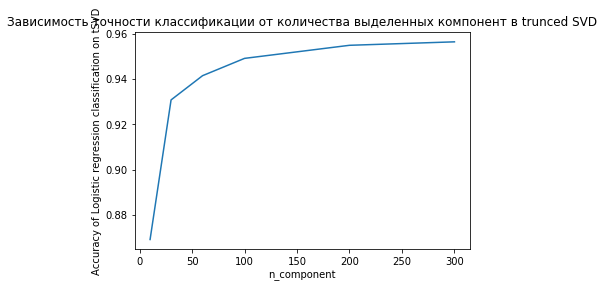

In [165]:
plt.title('Зависимость точности классификации от количества выделенных компонент в trunced SVD')
plt.xlabel('n_component')
plt.ylabel('Accuracy of Logistic regression classification on tSVD')
plt.plot(comp_iter, res_svd)
plt.show()

Вывод: уменьшив, количество фич с помощью сингурярного разложения truncated SVD, мы получили почти сходный результат, но модель будет работать быстрее. Уменьшение признаков с 46067 до 200 - в 230 раз. Пострадает интерпретируемость результатов. Увеличение количества итераций влияет на результат не значительно

### 3.3.2 формирование матрицы фич с помощью tfidf и тематические модели LDA

In [160]:
lda10 = LatentDirichletAllocation(n_components=10, random_state=42)
X_lda10 = lda10.fit_transform(X_tfidf1)

In [163]:
X_train_lda10, X_test_lda10, y_train_lda10, y_test_lda10 = train_test_split(X_lda10, y, test_size=0.2, random_state=42, stratify=y)
clf_lda10 = LogisticRegression(random_state=0).fit(X_train_lda10, y_train_lda10)
clf_lda10.score(X_test_lda10, y_test_lda10)

0.6506802721088435

In [168]:
res_lda = []
comp_iter = [10,30,60,100,200,300]
for ncomp in comp_iter:
    lda = LatentDirichletAllocation(n_components=ncomp, random_state=42)
    X_lda = lda.fit_transform(X_tfidf1)
    X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(X_lda, y, test_size=0.2, random_state=42, stratify=y)
    clf_lda = LogisticRegression(random_state=0).fit(X_train_lda, y_train_lda)
    res_lda.append(clf_lda.score(X_test_lda, y_test_lda))

In [174]:
y_pred_lda = clf_lda.predict(X_test_lda)
target_names = ['Score 5', 'Score 1']
print(classification_report(y_test_lda, y_pred_lda))

              precision    recall  f1-score   support

           1       0.85      0.84      0.85      2940
           5       0.84      0.86      0.85      2940

    accuracy                           0.85      5880
   macro avg       0.85      0.85      0.85      5880
weighted avg       0.85      0.85      0.85      5880



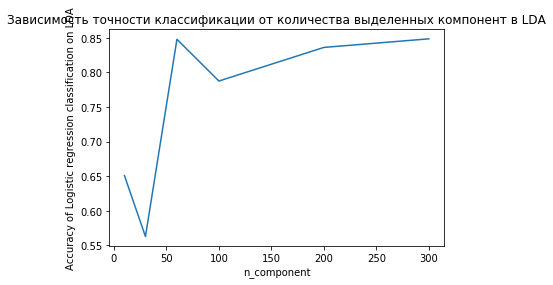

In [169]:
plt.title('Зависимость точности классификации от количества выделенных компонент в LDA')
plt.xlabel('n_component')
plt.ylabel('Accuracy of Logistic regression classification on LDA')
plt.plot(comp_iter, res_lda)
plt.show()

Вывод: tSVD гораздо более быстрый и показывает лучшие резуьлтаты при выделении того же количества компонент